In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.replay import replay_run, replay_fig, replay_participation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
from matplotlib.ticker import AutoMinorLocator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
df = pd.DataFrame()
df["basepath"] = [
    "Z:\Data\Can\OML22\day6",
    "Z:\Data\Can\OML22\day7",
    "Z:\Data\Can\OML22\day8",
    "Z:\Data\Can\OML22\day19",
    "Z:\Data\Can\OML22\day20",
]
df


,basepath
0,Z:\Data\Can\OML22\day6
1,Z:\Data\Can\OML22\day7
2,Z:\Data\Can\OML22\day8
3,Z:\Data\Can\OML22\day19
4,Z:\Data\Can\OML22\day20


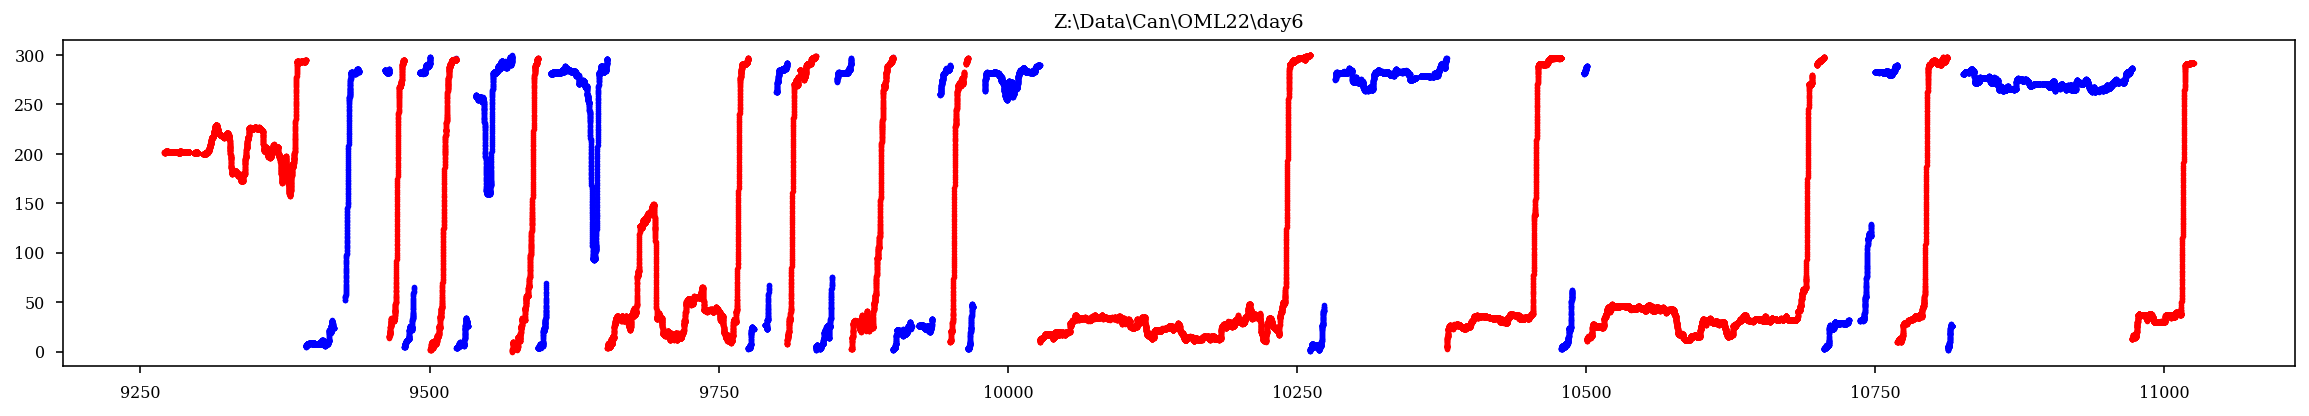

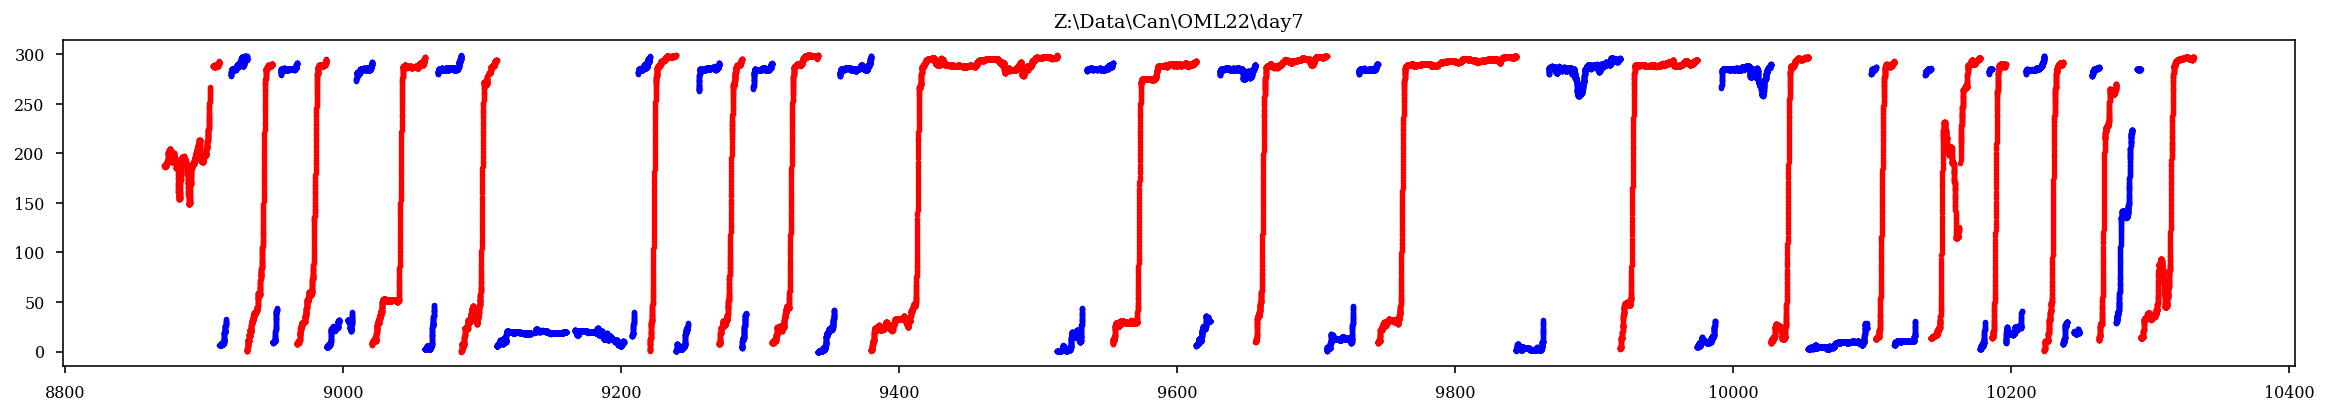

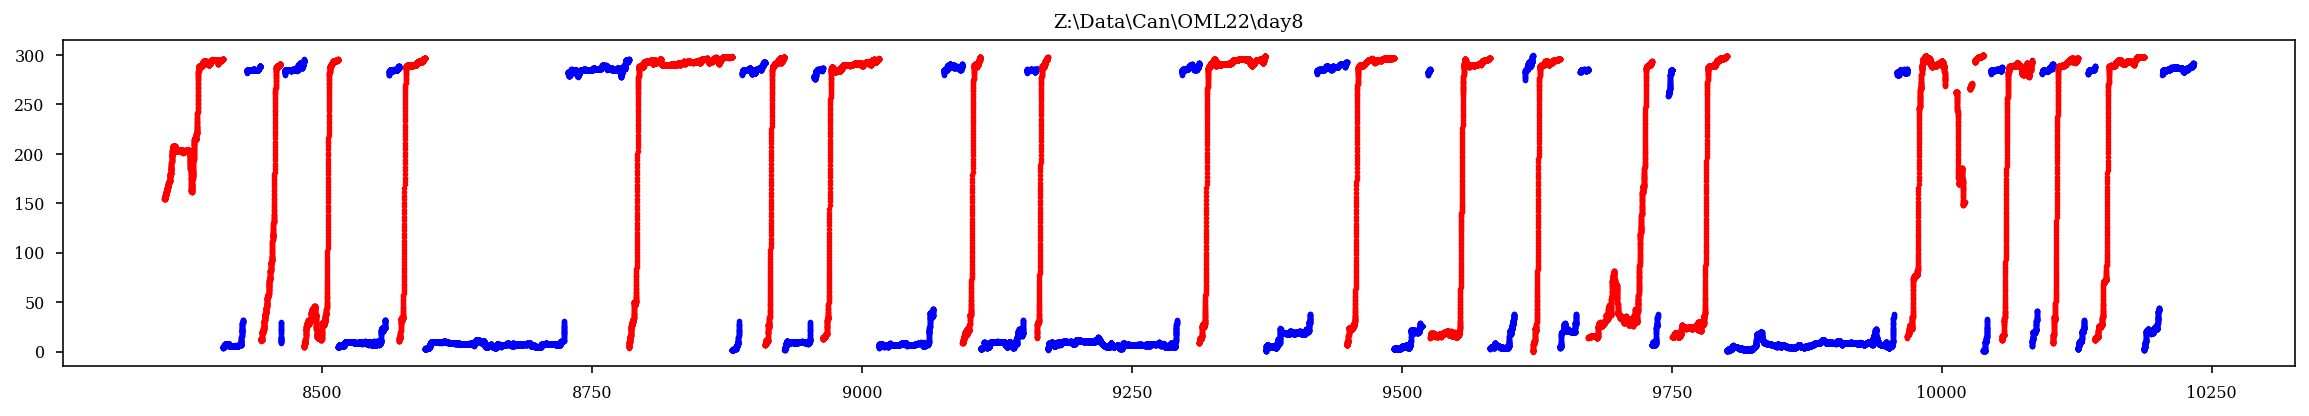

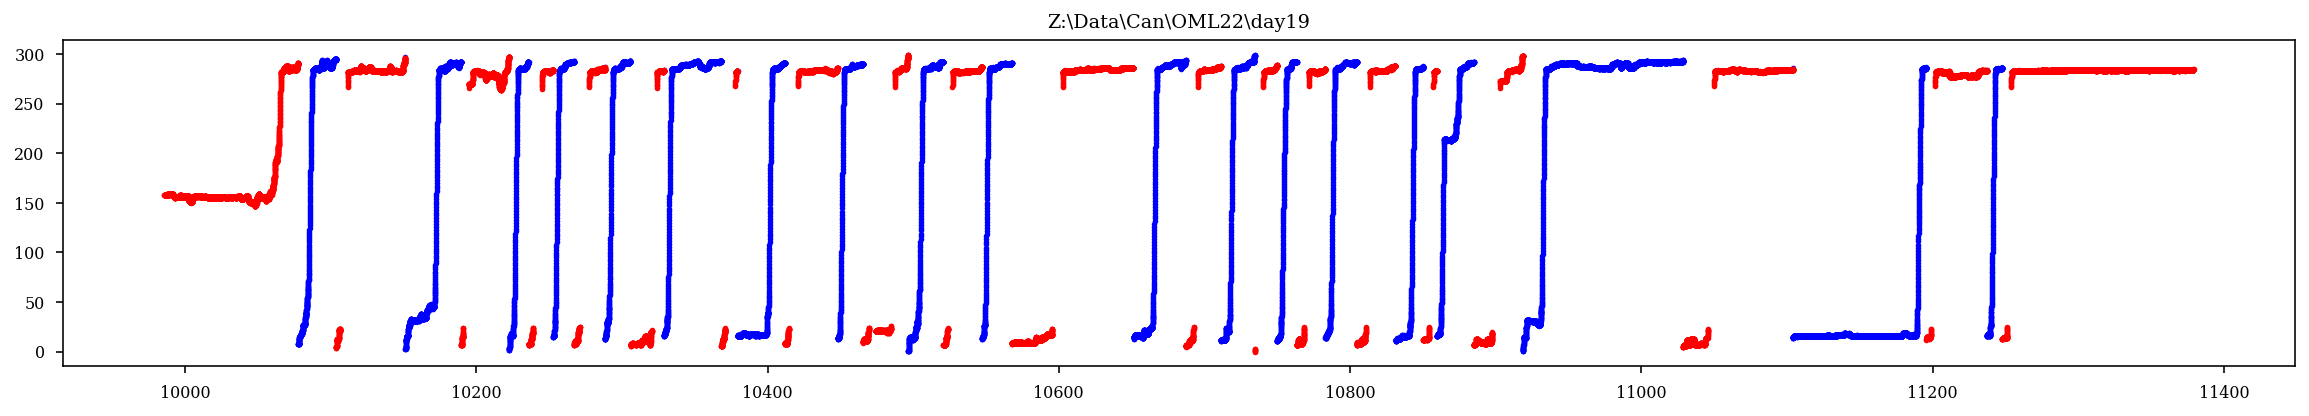

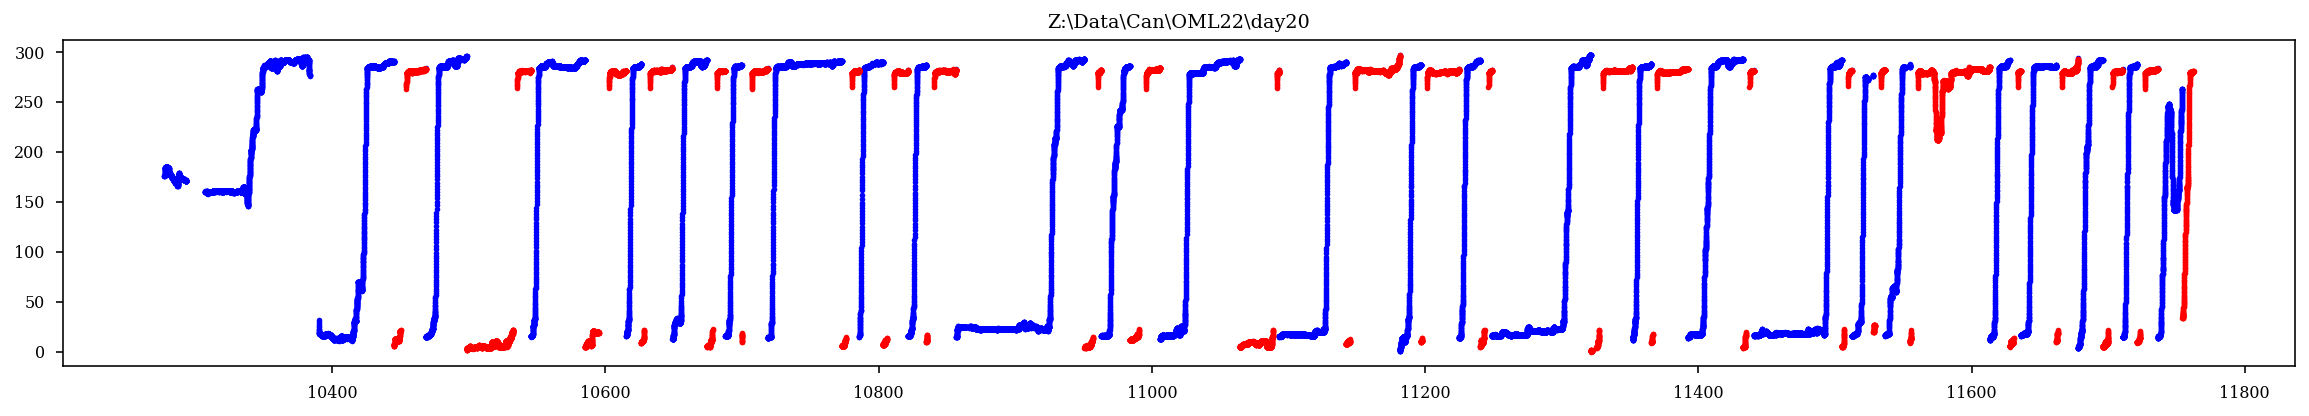

In [4]:
for basepath in df.basepath.unique():
    manipulation_epochs = loading.load_manipulation(basepath, struct_name="optoStim", merge_gap=1)
    epoch_df = loading.load_epoch(basepath)

    # compress repeated sleep sessions
    epoch_df = compress_repeated_epochs.main(epoch_df)
    # put into nel format
    beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])

    # results = replay_run.run_all(basepath)
    pos, outbound_epochs, inbound_epochs = replay_run.handle_behavior(
        basepath, epoch_df, beh_epochs, manipulation_epochs=manipulation_epochs,
    )
    # pos = pos[~df_manipulation]
    # outbound_epochs = outbound_epochs[~df_manipulation]
    # inbound_epochs = inbound_epochs[~df_manipulation]

    plt.figure(figsize=(20, 3))
    plt.plot(pos[outbound_epochs].abscissa_vals, pos[outbound_epochs].data.T,'.b')
    plt.plot(pos[inbound_epochs].abscissa_vals,pos[inbound_epochs].data.T,'.r')

    plt.title(basepath) 

In [26]:
df[df.score_pval_time_swap < 0.05][['basepath', 'direction']].value_counts()

basepath                 direction      
Z:\Data\Can\OML22\day7   inbound_epochs     128
                         outbound_epochs    101
Z:\Data\Can\OML22\day6   inbound_epochs      99
                         outbound_epochs     99
Z:\Data\Can\OML22\day8   inbound_epochs      96
                         outbound_epochs     81
Z:\Data\Can\OML22\day20  outbound_epochs     47
dtype: int64

In [7]:
basepath = r"Z:\Data\Can\OML22\day19"
# basepath = r"Z:\Data\AYAold\AB1\day1"
results = replay_run.run_all(basepath,traj_shuff=2, behav_shuff=2,shuffle_parallel=True)


In [8]:
results['inbound_epochs']['decoding_median_error']

7.327378701031149

In [ ]:
results['outbound_epochs']['df']

sns.pairplot(results['outbound_epochs']['df'][["trajectory_score",
                                            "avg_jump",
                                            "radon_score"]])


In [11]:
# basepath = r"Z:\Data\Can\OML22\day7"
basepath = r"Z:\Data\Can\OML22\day6"

results = replay_run.run_all(basepath,traj_shuff=2, behav_shuff=2,shuffle_parallel=False)


In [12]:
sum(results['outbound_epochs']['df'].score_pval_time_swap < 0.05), sum(results['inbound_epochs']['df'].score_pval_time_swap < 0.05)

(0, 0)

In [41]:
bst_placecells = results['inbound_epochs']["bst_placecells"]
bst_placecells.ds

dir(bst_placecells)
tc = results['inbound_epochs']["tc"]
dir(tc)
np.diff(tc.bins)[0]

3.0

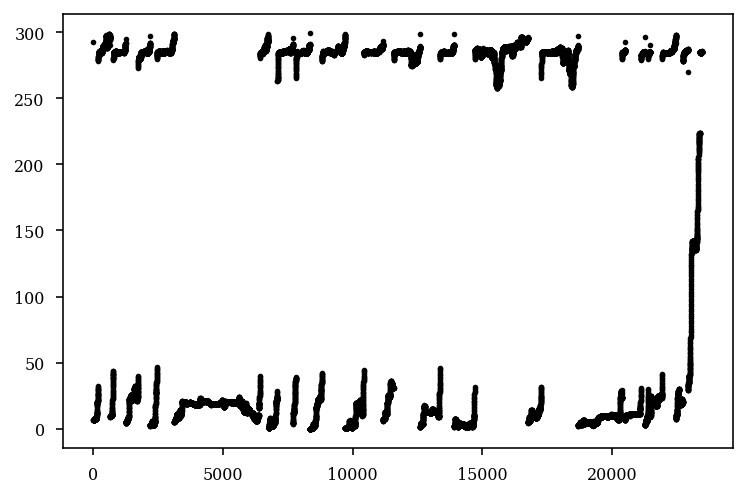

In [8]:
results['outbound_epochs']['df']
# results['inbound_epochs']['df']

plt.plot(results['outbound_epochs']['pos'].data.T,'.k')

plt.show()

In [4]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_cans_rats_5262022"

batch_analysis.run(
    df,
    save_path,
    replay_run.run_all,
    parallel=True,
    traj_shuff=1000,
    verbose=True,
    place_cell_peak_mean_ratio=1,
    expand_canidate_by_mua=False,
)


100%|██████████| 5/5 [00:00<00:00, 845.22it/s]


In [6]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_cans_rats_5262022"

df = replay_run.load_results(save_path, pre_task_post=False)


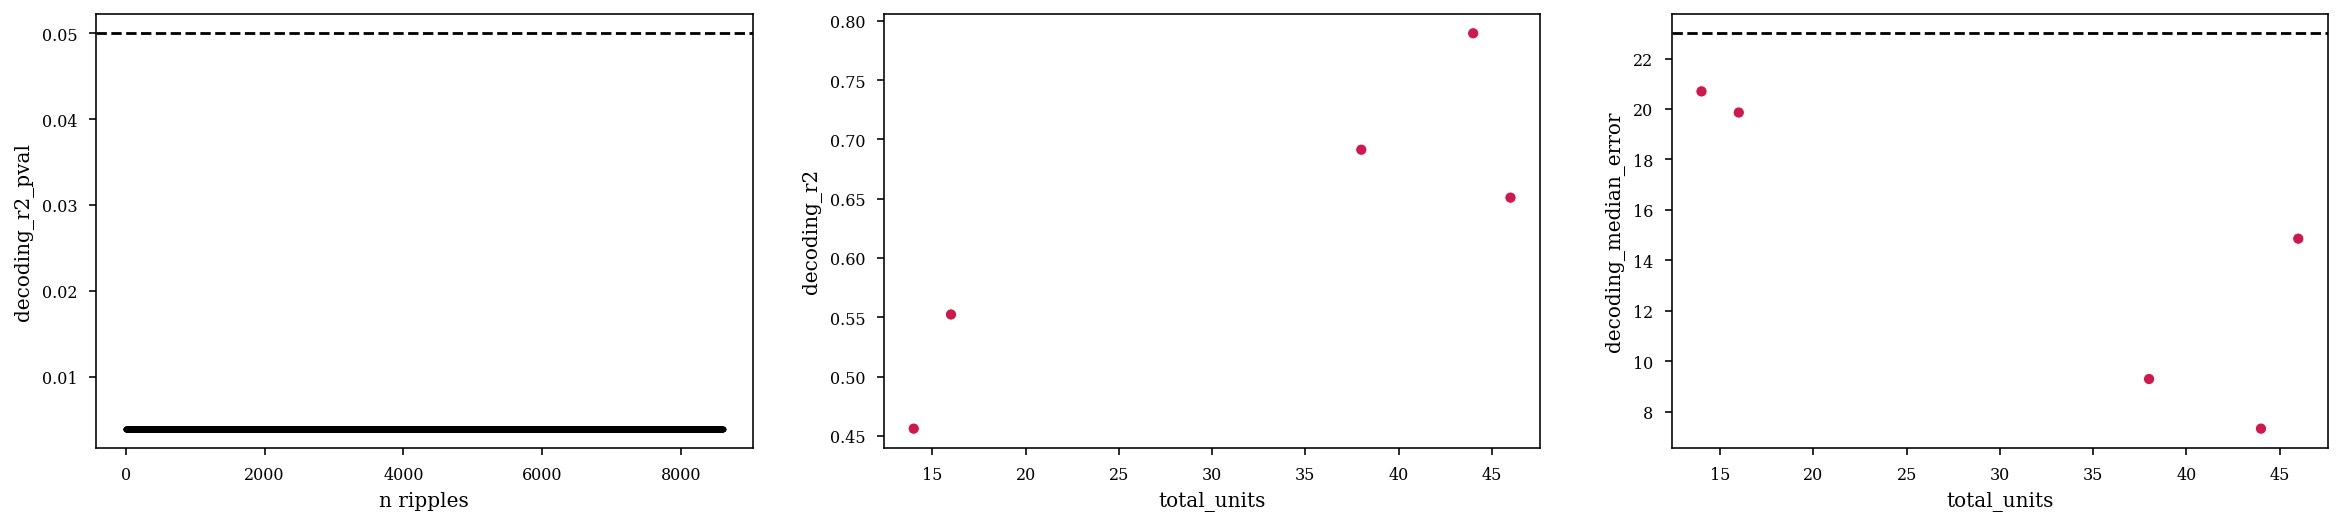

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0].plot(df.decoding_r2_pval, ".k")
axs[0].set_ylabel("decoding_r2_pval")
axs[0].set_xlabel("n ripples")
axs[0].axhline(0.05, color="k", linestyle="--")

sns.scatterplot(
    x="total_units",
    y="decoding_r2",
    hue=df.decoding_median_error < 23,
    data=df,
    ax=axs[1],
    legend=False,
    palette="rocket_r",
)

sns.scatterplot(
    x="total_units",
    y="decoding_median_error",
    hue=df.decoding_median_error < 23,
    palette="rocket_r",
    data=df,
    ax=axs[2],
    legend=False,
)
# axs[2].legend(bbox_to_anchor=(1.1, 1.05))
axs[2].axhline(23, color="k", linestyle="--")


In [8]:
df[df.decoding_median_error > 23][["basepath", "direction"]].value_counts()


Series([], dtype: int64)

In [9]:
print(df[df.decoding_r2_pval > 0.05].basepath.unique())
print(df[df.decoding_median_error > 23].basepath.unique())


[]
[]


In [10]:
df = df[(df.decoding_r2_pval < 0.05) & (df.decoding_median_error < 23)]


In [11]:
df[df.score_pval_time_swap < 0.05].basepath.value_counts()


Z:\Data\Can\OML22\day6     126
Z:\Data\Can\OML22\day7      97
Z:\Data\Can\OML22\day8      76
Z:\Data\Can\OML22\day19     65
Z:\Data\Can\OML22\day20     44
Name: basepath, dtype: int64

In [12]:
df.head()


,start,stop,duration,n_active,inactive_bin_prop,trajectory_score,r_squared,slope,intercept,score_pval_time_swap,...,traj_speed,traj_step,replay_type,pop_partic,decoding_r2,decoding_r2_pval,decoding_median_error,total_units,direction,basepath
0,10.9224,11.0096,0.0872,9,0.00,0.178534,0.068964,11.781250,94.854167,0.247752,...,589.062500,11.781250,forward,0.642857,0.456086,0.003984,20.697133,14.0,outbound_epochs,Z:\Data\Can\OML22\day19
1,27.7288,27.8624,0.1336,7,0.00,0.126466,0.801062,-45.053571,450.938492,0.138861,...,2252.678571,45.053571,reverse,0.500000,0.456086,0.003984,20.697133,14.0,outbound_epochs,Z:\Data\Can\OML22\day19
2,77.1120,77.1936,0.0816,5,0.25,0.014644,0.140849,54.375000,-520.590278,1.000000,...,2718.750000,54.375000,forward,0.357143,0.456086,0.003984,20.697133,14.0,outbound_epochs,Z:\Data\Can\OML22\day19
3,77.5064,77.5976,0.0912,10,0.00,0.206867,0.276435,29.906250,-384.250000,0.175824,...,1495.312500,29.906250,forward,0.714286,0.456086,0.003984,20.697133,14.0,outbound_epochs,Z:\Data\Can\OML22\day19
4,86.0200,86.1280,0.1080,5,0.40,0.029096,0.531856,-96.666667,2212.256944,0.878122,...,4833.333333,96.666667,reverse,0.357143,0.456086,0.003984,20.697133,14.0,outbound_epochs,Z:\Data\Can\OML22\day19


In [36]:
df.keys()


Index(['start', 'stop', 'duration', 'n_active', 'inactive_bin_prop',
       'trajectory_score', 'r_squared', 'slope', 'intercept',
       'score_pval_time_swap', 'score_pval_col_cycle', 'traj_dist',
       'traj_speed', 'traj_step', 'replay_type', 'pop_partic', 'decoding_r2',
       'decoding_r2_pval', 'decoding_median_error', 'total_units', 'direction',
       'basepath'],
      dtype='object')

In [13]:
pd.crosstab(df.replay_type, df.direction).apply(lambda r: r / r.sum(), axis=1)


direction,inbound_epochs,outbound_epochs
replay_type,,
forward,0.713255,0.286745
reverse,0.711746,0.288254
unknown,0.833333,0.166667


In [38]:
# get proportion of canidates that are replay events
df.replay_type.value_counts() / df.replay_type.value_counts().sum()


forward    0.503435
reverse    0.492485
unknown    0.004080
Name: replay_type, dtype: float64

In [39]:
print(
    ((df.score_pval_time_swap < 0.05) & (df.direction == "inbound_epochs")).sum()
    / (df.direction == "inbound_epochs").sum()
)
print(
    ((df.score_pval_time_swap < 0.05) & (df.direction == "outbound_epochs")).sum()
    / (df.direction == "outbound_epochs").sum()
)


0.047722029988465975
0.03936895963615691


In [40]:
res = (
    pd.crosstab(df.replay_type, df.direction, margins=True, margins_name="Total")
    .iloc[:, :-1]
    .rename_axis(None)
)
display(res)
res = (
    pd.crosstab(
        df[df.score_pval_time_swap < 0.05].replay_type,
        df[df.score_pval_time_swap < 0.05].direction,
        margins=True,
        margins_name="Total",
    )
    .iloc[:, :-1]
    .rename_axis(None)
)
res


direction,inbound_epochs,outbound_epochs
forward,3530,3504
reverse,3391,3490
unknown,15,42
Total,6936,7036


direction,inbound_epochs,outbound_epochs
forward,178,144
reverse,153,132
unknown,0,1
Total,331,277


In [41]:
df[df.score_pval_time_swap < 0.05].replay_type.value_counts()


forward    322
reverse    285
unknown      1
Name: replay_type, dtype: int64

<AxesSubplot:xlabel='direction', ylabel='pop_partic'>

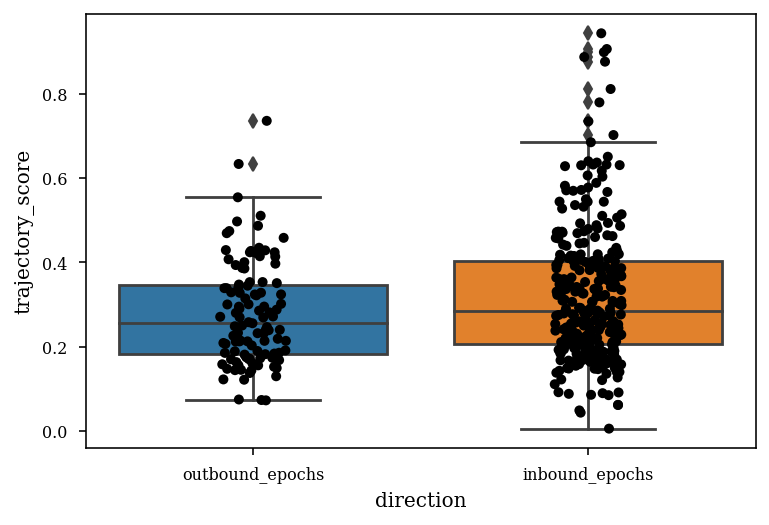

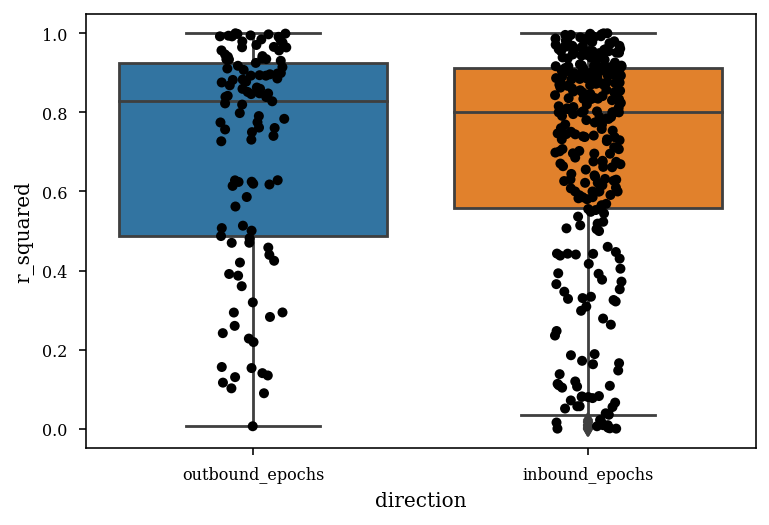

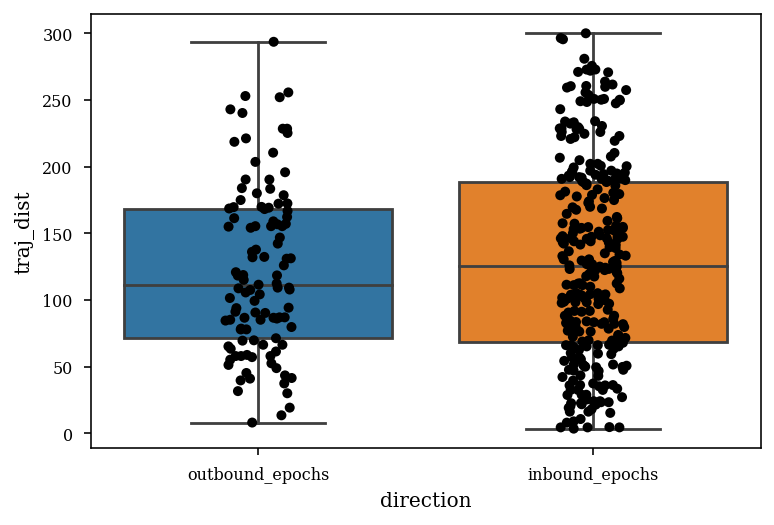

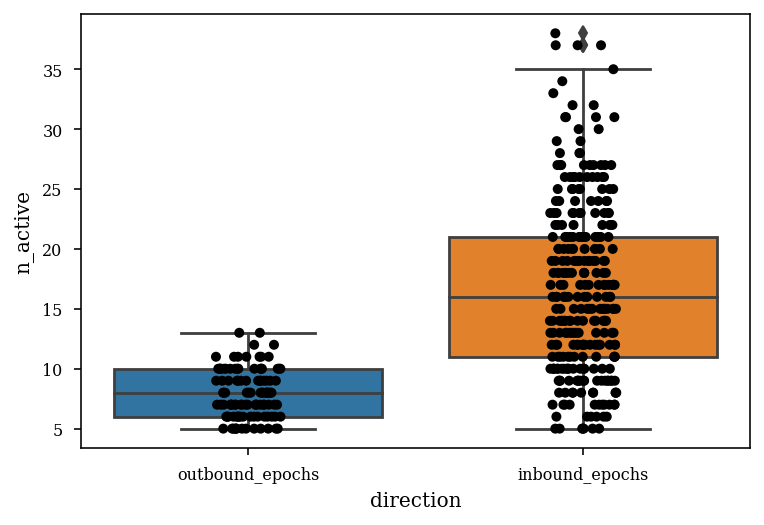

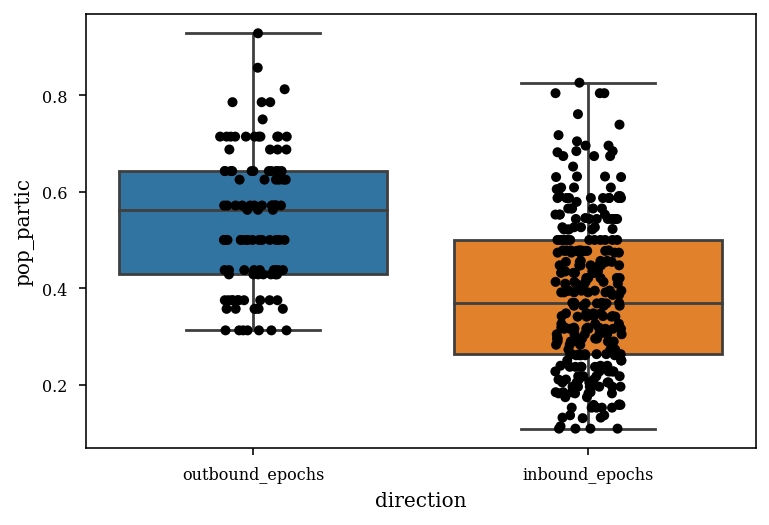

In [14]:
sns.boxplot(
    x="direction", y="trajectory_score", data=df[df.score_pval_time_swap < 0.05]
)
sns.stripplot(
    x="direction",
    y="trajectory_score",
    data=df[df.score_pval_time_swap < 0.05],
    color="k",
)

plt.figure()
sns.boxplot(x="direction", y="r_squared", data=df[df.score_pval_time_swap < 0.05])
sns.stripplot(
    x="direction", y="r_squared", data=df[df.score_pval_time_swap < 0.05], color="k"
)

plt.figure()
sns.boxplot(x="direction", y="traj_dist", data=df[df.score_pval_time_swap < 0.05])
sns.stripplot(
    x="direction", y="traj_dist", data=df[df.score_pval_time_swap < 0.05], color="k"
)


plt.figure()
sns.boxplot(x="direction", y="n_active", data=df[df.score_pval_time_swap < 0.05])
sns.stripplot(
    x="direction", y="n_active", data=df[df.score_pval_time_swap < 0.05], color="k"
)

plt.figure()
sns.boxplot(x="direction", y="pop_partic", data=df[df.score_pval_time_swap < 0.05])
sns.stripplot(
    x="direction", y="pop_partic", data=df[df.score_pval_time_swap < 0.05], color="k"
)


## example replay figs

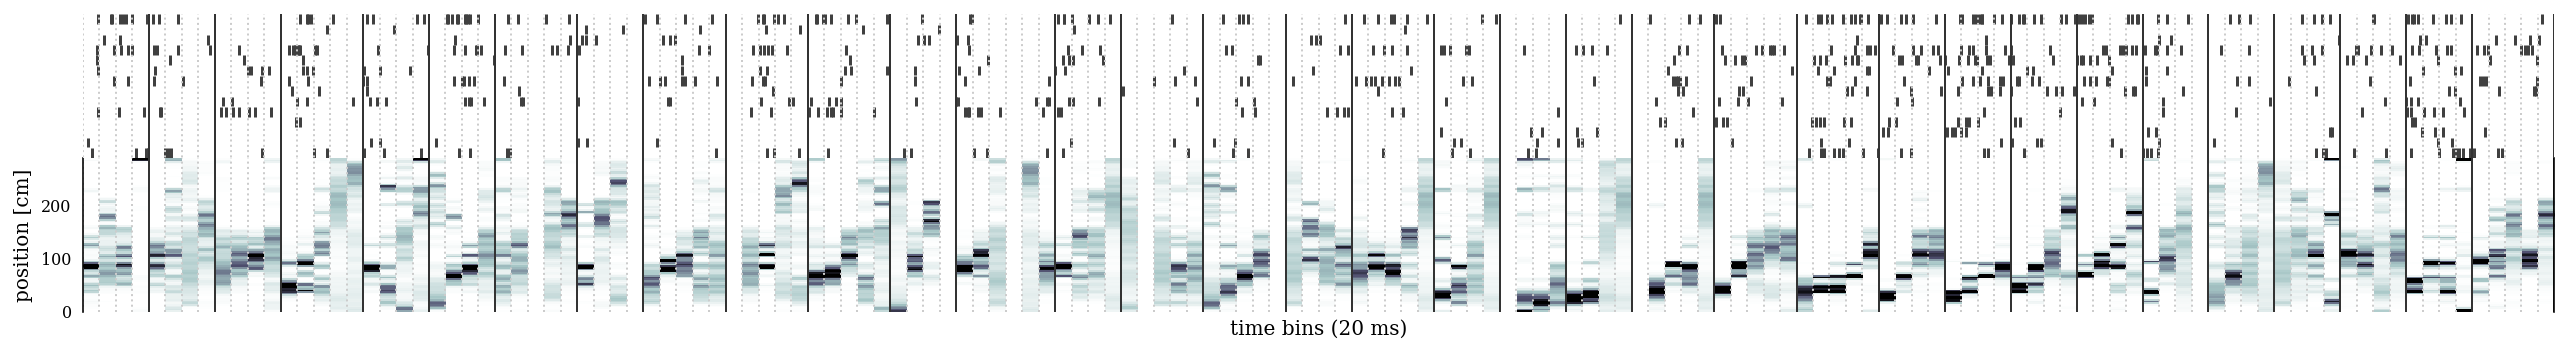

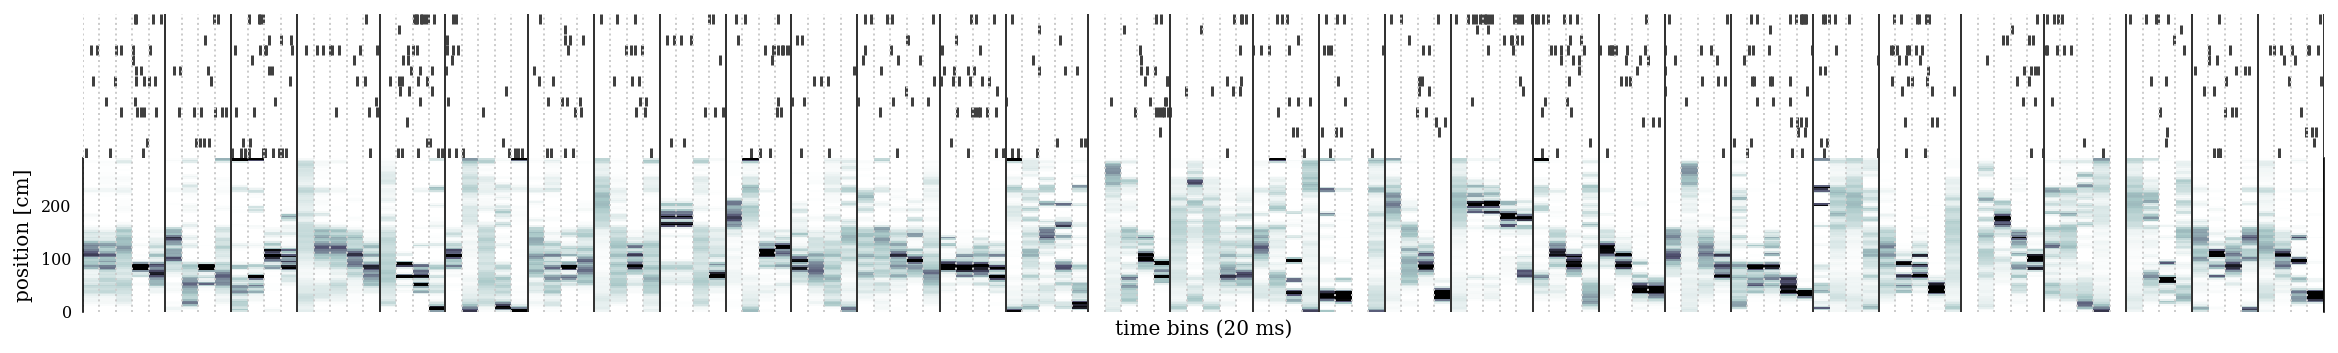

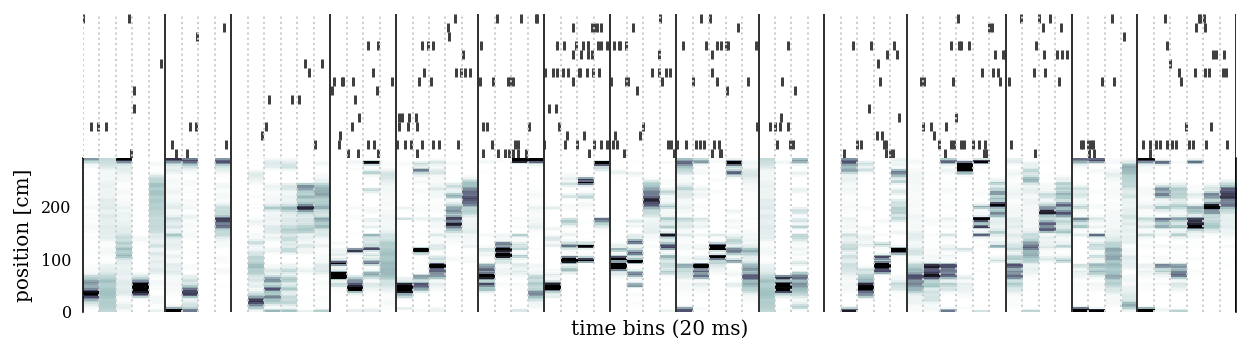

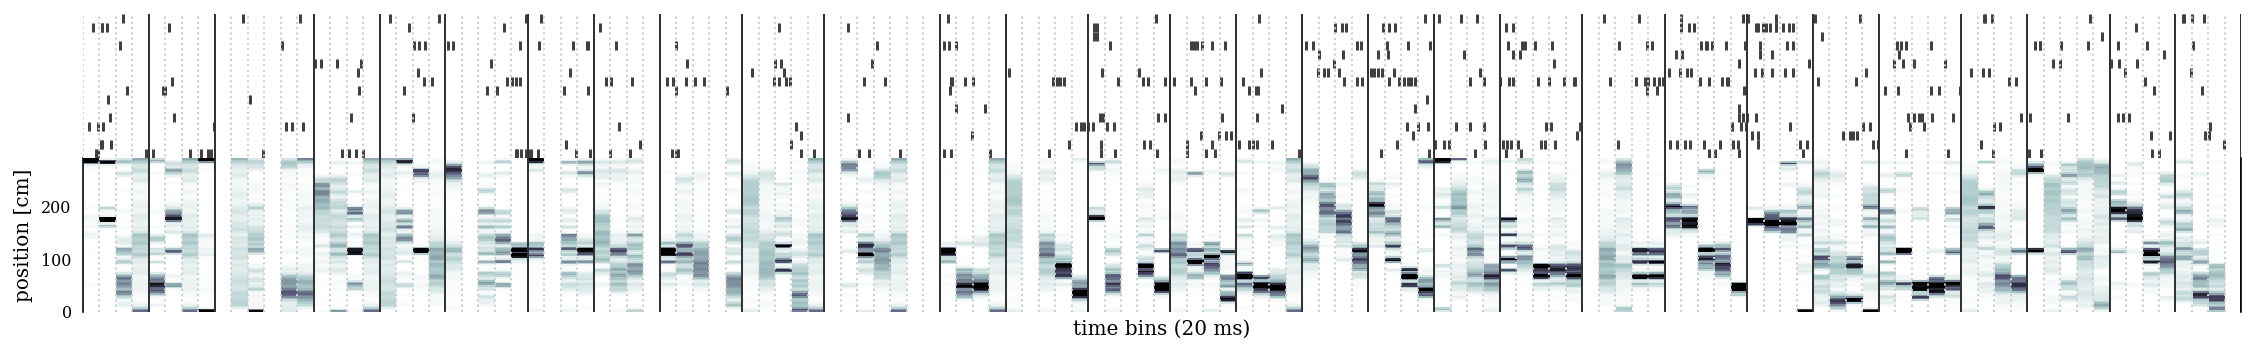

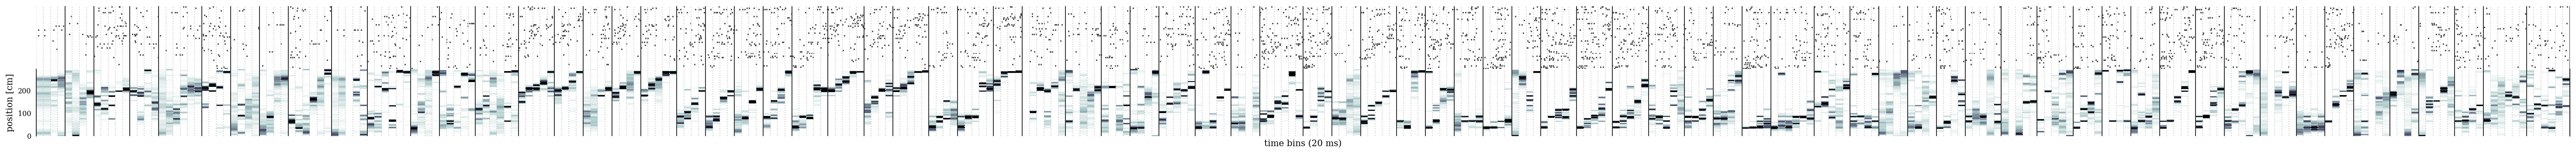

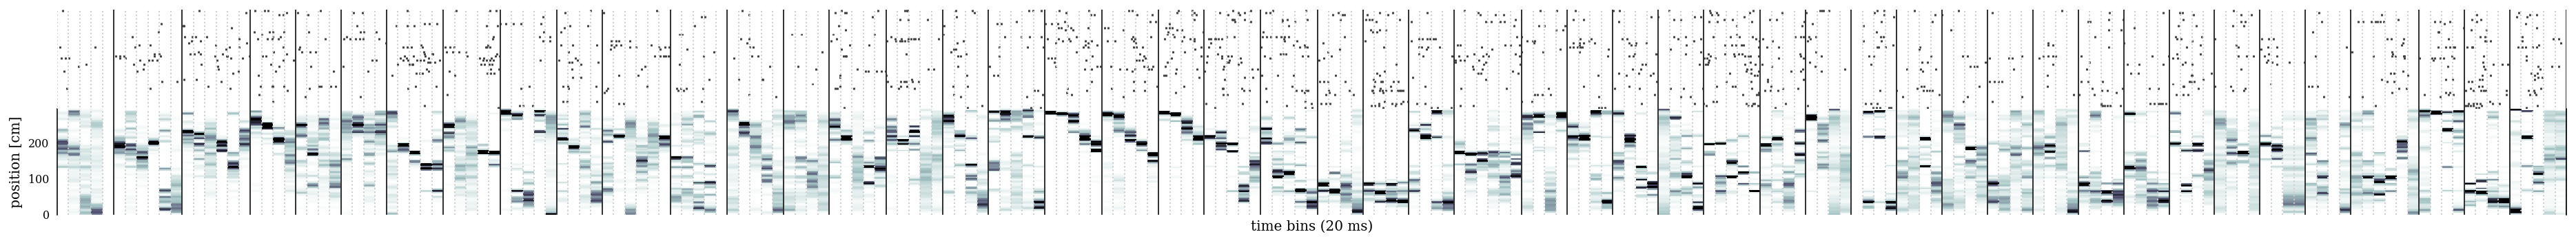

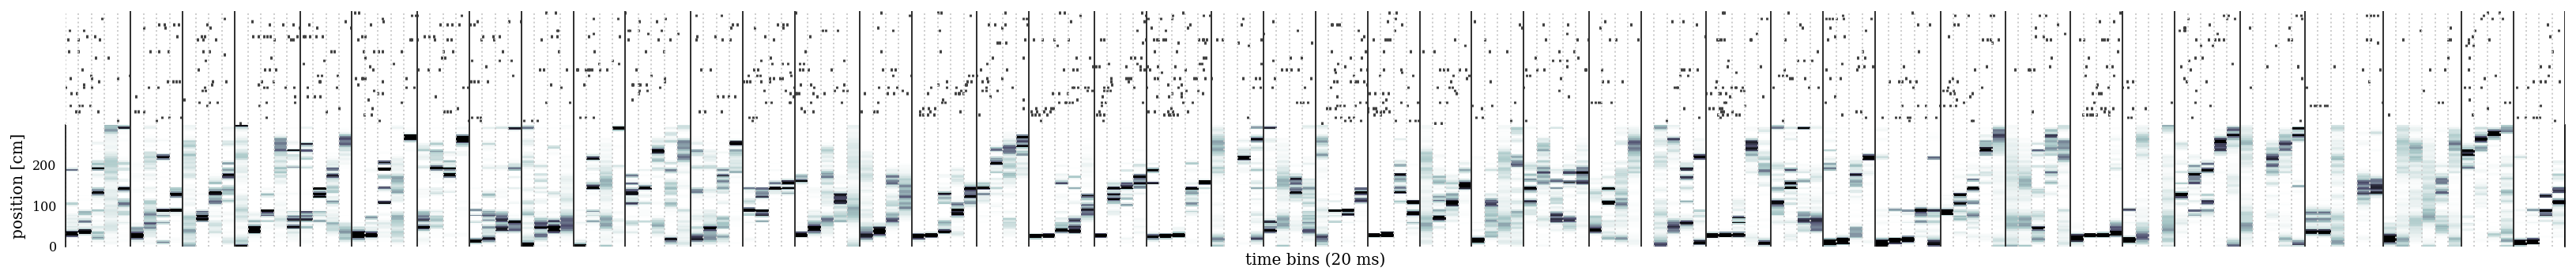

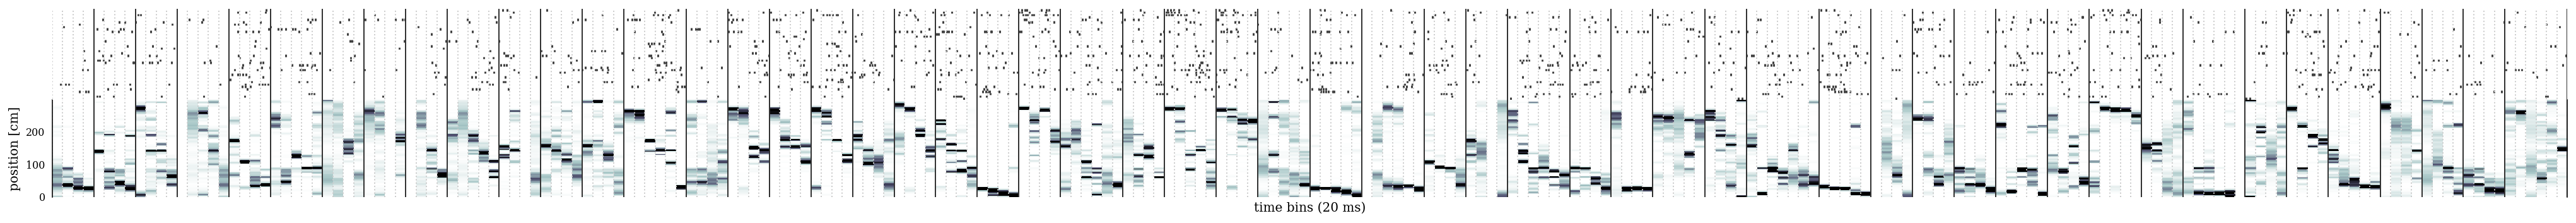

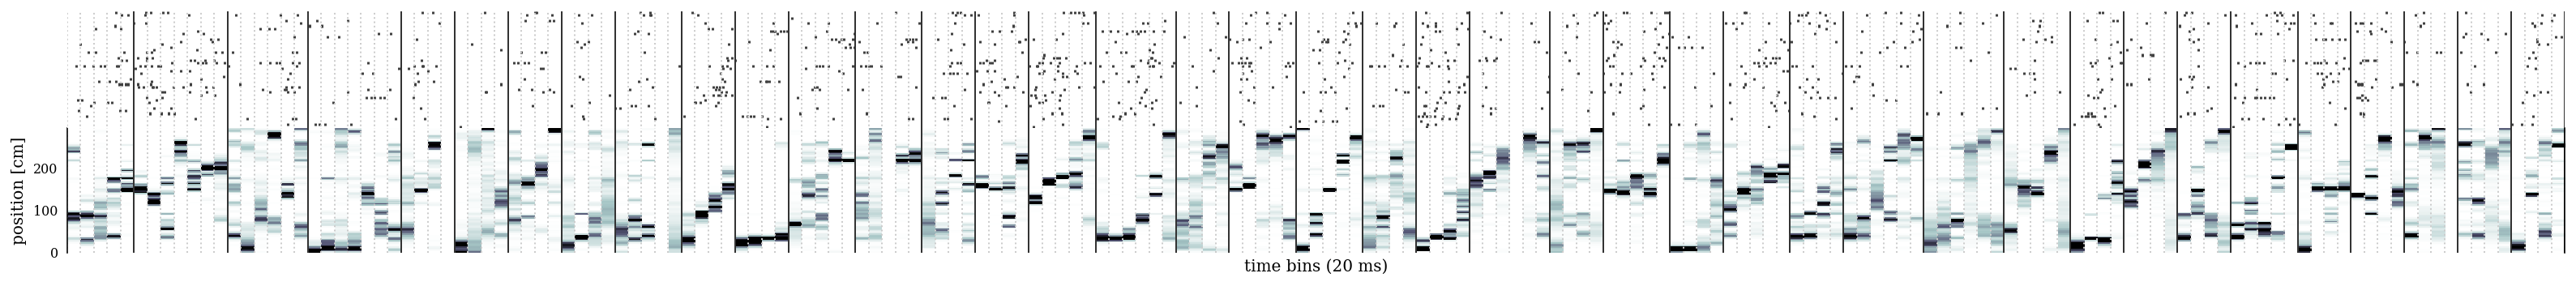

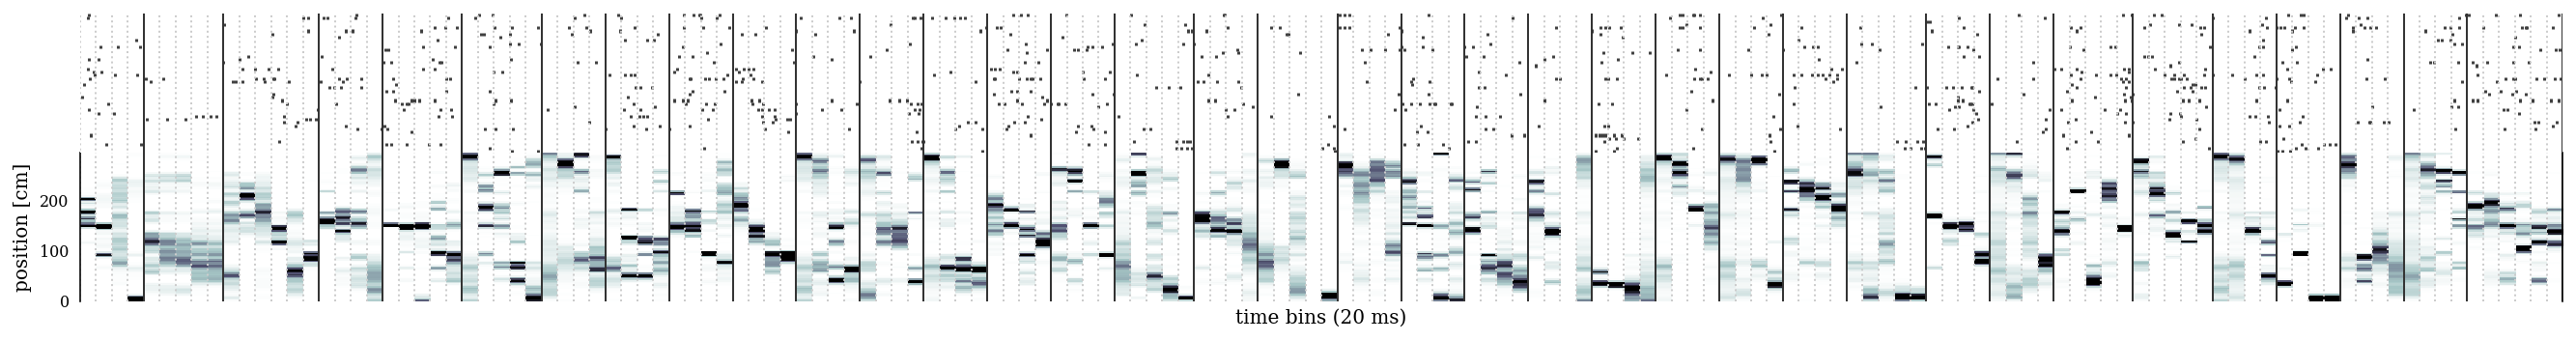

In [20]:
def plot_the_replays(results,dir_epoch,replay_type):
    try:
        basepath = results[dir_epoch]["session"]
    except:
        return
    animal_name = loading.get_animal_id(basepath)
    basename = os.path.basename(basepath)

    idx = np.where(
        (results[dir_epoch]["df"].score_pval_time_swap < 0.05)
        & (results[dir_epoch]["df"].replay_type == replay_type)
    )[0]

    if (results[dir_epoch]["decoding_r2_pval"] > 0.05) | (
        results[dir_epoch]["decoding_median_error"] > 30
    ):
        idx = []

    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(
            results[dir_epoch]["bst_placecells"][idx],
            results[dir_epoch]["sta_placecells"],
            results[dir_epoch]["tc"],
            results[dir_epoch]["tc"],
            vmax=0.1,
        )
        fig.savefig(
            os.path.join(
                fig_save_path,
                "replay_examples",
                basename + "_" + animal_name + dir_epoch + replay_type + ".jpeg",
            ),
            dpi=300,
            bbox_inches="tight",
        )
        plt.close(fig)

sessions = glob.glob(save_path + os.sep + "*.pkl")
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)

    if results is None:
        continue
    
    plot_the_replays(results,"outbound_epochs","forward")
    plot_the_replays(results,"inbound_epochs","forward")
    plot_the_replays(results,"outbound_epochs","reverse")
    plot_the_replays(results,"inbound_epochs","reverse")



In [71]:
from ripple_heterogeneity.replay import (
    replay_run,
    replay_participation_all_replays,
)
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_cans_rats"

replay_df = replay_run.load_results(save_path, pre_task_post=False)


In [78]:
basepath = r"Z:\Data\Can\OML22\day8"
temp_df = replay_participation_all_replays.run(basepath,
    replay_df=replay_df,
    replay_save_path=save_path,
    environments=["home", "linear", "home"],
    min_env_criteria = ["home", "linear"],
    epochs_to_combine=["linear", "home"],
    alpha=0.05,
    min_spk_count=0
    )

In [81]:
temp_df

,avg_fr,non_ripple_avg_fr,replay_fr,ripple_fr,non_replay_fr,replay_par,ripple_par,non_replay_par,forward_replay_par,reverse_replay_par,epoch,epoch_i,UID,deepSuperficialDistance,n_replays,n_forward_replays,n_reverse_replays,n_ripples,basepath
0,0.881229,0.735520,2.952195,2.489711,5.646673,0.320000,0.236819,0.321668,0.208333,0.423077,home,0,1,223.063385,50,24,26,6714,Z:\Data\Can\OML22\day8
1,0.416389,0.348901,0.916198,1.104244,2.092720,0.140000,0.109026,0.149665,0.083333,0.192308,home,0,10,-71.309773,50,24,26,6714,Z:\Data\Can\OML22\day8
2,1.340792,0.989620,8.143986,4.830944,11.682517,0.640000,0.380548,0.542070,0.625000,0.653846,home,0,14,21.952752,50,24,26,6714,Z:\Data\Can\OML22\day8
3,2.935951,2.820374,2.646795,3.487758,6.028502,0.280000,0.261990,0.312733,0.333333,0.230769,home,0,17,-116.936615,50,24,26,6714,Z:\Data\Can\OML22\day8
4,0.667638,0.518762,3.257594,2.130807,6.035845,0.340000,0.195264,0.333582,0.333333,0.346154,home,0,18,-116.936615,50,24,26,6714,Z:\Data\Can\OML22\day8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.854671,0.603654,3.860079,2.718369,7.001289,0.339130,0.209716,0.322192,0.316667,0.350877,linear_home,1,87,-78.047248,115,60,57,12598,Z:\Data\Can\OML22\day8
100,1.580259,1.382993,4.037554,2.976579,7.066364,0.373913,0.268138,0.390595,0.333333,0.438596,linear_home,1,89,-11.309773,115,60,57,12598,Z:\Data\Can\OML22\day8
101,1.999324,1.820276,4.569978,3.581545,6.905591,0.339130,0.218368,0.258065,0.316667,0.350877,linear_home,1,90,-91.309773,115,60,57,12598,Z:\Data\Can\OML22\day8
102,1.625687,1.349518,4.703085,3.505725,7.774532,0.382609,0.254405,0.357171,0.416667,0.333333,linear_home,1,93,-36.936615,115,60,57,12598,Z:\Data\Can\OML22\day8


In [83]:
save_path_cur_analysis = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_can_rats"
)
batch_analysis.run(
    replay_df,
    save_path_cur_analysis,
    replay_participation_all_replays.run,
    parallel=True,
    verbose=True,
    overwrite=False,
    skip_if_error=False,
    replay_df=replay_df,
    replay_save_path=save_path,
    environments=["home", "linear", "home"],
    min_env_criteria = ["home", "linear"],
    epochs_to_combine=["linear", "home"],
    alpha=0.05,
    min_spk_count=0,
)

sessions = glob.glob(save_path_cur_analysis + os.sep + "*.pkl")
par_df = pd.DataFrame()
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)
    par_df = pd.concat([par_df, results])

100%|██████████| 5/5 [00:00<00:00, 2448.80it/s]


In [86]:
par_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(par_df)
for basepath in par_df.basepath.unique():
    par_df.loc[par_df.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)

(0.0, 1.0)

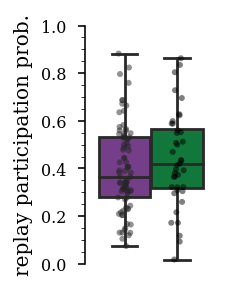

In [93]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

# keep_idx = (par_df.n_replays > 30) & (~par_df.basepath.str.contains('GirardeauG'))
keep_idx = (par_df.n_replays > 30) & (par_df.epoch.str.contains("linear"))

sns.boxplot(
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("replay participation prob.")

ax.set_ylim(0,1)
# plt.savefig(
#     os.path.join(fig_save_path, "replay_participation_05_19_22.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

<AxesSubplot:xlabel='replay_par', ylabel='Proportion'>

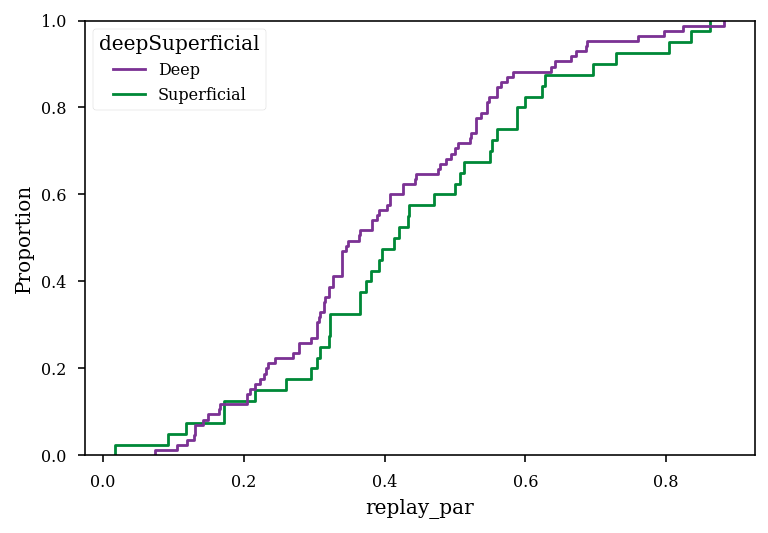

In [91]:
sns.ecdfplot(
    x="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
)

# sns.ecdfplot(
#     data=df, x="traj_speed", hue="gmm_labels", hue_order=group_colors.keys()
# )

In [94]:
keep_idx = (par_df.n_replays > 30) & (par_df.epoch.str.contains("linear"))

par_df_long = pd.melt(
    par_df[keep_idx],
    id_vars=["basepath", "UID", "deepSuperficial"],
    value_vars=["forward_replay_par", "reverse_replay_par"],
    var_name="replay_type",
    value_name="replay_participation",
)
par_df_long

,basepath,UID,deepSuperficial,replay_type,replay_participation
0,Z:\Data\Can\OML22\day19,16,middle,forward_replay_par,0.692308
1,Z:\Data\Can\OML22\day19,18,Superficial,forward_replay_par,0.576923
2,Z:\Data\Can\OML22\day19,23,middle,forward_replay_par,0.653846
3,Z:\Data\Can\OML22\day19,25,Superficial,forward_replay_par,0.807692
4,Z:\Data\Can\OML22\day19,26,middle,forward_replay_par,0.423077
...,...,...,...,...,...
369,Z:\Data\Can\OML22\day8,87,Deep,reverse_replay_par,0.350877
370,Z:\Data\Can\OML22\day8,89,middle,reverse_replay_par,0.438596
371,Z:\Data\Can\OML22\day8,90,Deep,reverse_replay_par,0.350877
372,Z:\Data\Can\OML22\day8,93,Deep,reverse_replay_par,0.333333


(0.0, 1.0)

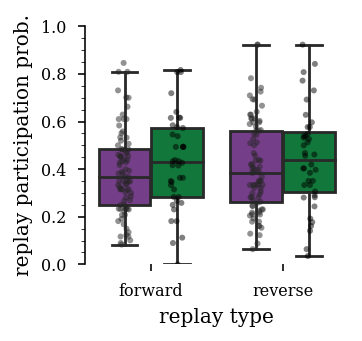

In [97]:
w,h = functions.set_size("thesis", fraction=0.2, subplots=(3, 1))

fig = plt.figure(
    figsize=(w*2,h), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

g=sns.boxplot(
    x="replay_type",
    y="replay_participation",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_long,
    showfliers=False,
)
sns.stripplot(
    x="replay_type",
    y="replay_participation",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_long,
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
ax = plt.gca()
ax.get_legend().remove()
sns.despine()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
# ax.get_legend().remove()
# ax.set_xlabel("")
# plt.xticks(['forward','reverse'], rotation='vertical')
ax.set_ylabel("replay participation prob.")
ax.set_xlabel("replay type")
g.set_xticklabels(['forward','reverse'])

ax.set_ylim(0,1)

In [47]:
import scipy.io as sio
import pandas as pd
import glob
from ripple_heterogeneity.utils import loading
import nelpy as nel
import numpy as np


def load_manipulation(
    basepath, struct_name=None, return_epoch_array=True, merge_gap=None
):
    """
    Loads the data from the basename.eventName.manipulations.mat file and returns a pandas dataframe

    file structure defined here:
        https://cellexplorer.org/datastructure/data-structure-and-format/#manipulations

    inputs:
        basepath: string, path to the basename.eventName.manipulations.mat file
        struct_name: string, name of the structure in the mat file to load. If None, loads all the manipulation files.
        return_epoch_array: bool, if True, returns only the epoch array
        merge_gap: int, if not None, merges the epochs that are separated by less than merge_gap (sec). return_epoch_array must be True.
    outputs:
        df: pandas dataframe, with the following columns:
            - start (float): start time of the manipulation in frames
            - stop (float): stop time of the manipulation in frames
            - peaks (float): list of the peak times of the manipulation in frames
            - center (float): center time of the manipulation in frames
            - duration (float): duration of the manipulation in frames
            - amplitude (float): amplitude of the manipulation
            - amplitudeUnit (string): unit of the amplitude
    Example:
        >> basepath = r"Z:\Data\Can\OML22\day8"
        >> df_manipulation = load_manipulation(basepath,struct_name="optoStim",return_epoch_array=False)
        >> df_manipulation.head(2)

                start	    stop	    peaks	    center	    duration amplitude amplitudeUnits
        0	8426.83650	8426.84845	8426.842475	8426.842475	0.01195	19651	pulse_respect_baseline
        1	8426.85245	8426.86745	8426.859950	8426.859950	0.01500	17516	pulse_respect_baseline

        >> basepath = r"Z:\Data\Can\OML22\day8"
        >> df_manipulation = load_manipulation(basepath,struct_name="optoStim",return_epoch_array=True)
        >> df_manipulation

        <EpochArray at 0x1faba577520: 5,774 epochs> of length 1:25:656 minutes
    """
    if struct_name is None:
        filename = glob.glob(basepath + os.sep + "*manipulation.mat")
        print(filename)
        if len(filename) > 1:
            raise ValueError(
                "multi-file not implemented yet...than one manipulation file found"
            )
        filename = filename[0]
    else:
        filename = glob.glob(
            basepath + os.sep + "*" + struct_name + ".manipulation.mat"
        )[0]

    # load matfile
    data = sio.loadmat(filename)

    if struct_name is None:
        struct_name = list(data.keys())[-1]

    df = pd.DataFrame()
    df["start"] = data[struct_name]["timestamps"][0][0][:, 0]
    df["stop"] = data[struct_name]["timestamps"][0][0][:, 1]
    df["peaks"] = data[struct_name]["peaks"][0][0]
    df["center"] = data[struct_name]["center"][0][0]
    df["duration"] = data[struct_name]["duration"][0][0]
    df["amplitude"] = data[struct_name]["amplitude"][0][0]
    df["amplitudeUnits"] = data[struct_name]["amplitudeUnits"][0][0][0]

    if return_epoch_array:
        # get session epochs to add support for epochs
        epoch_df = loading.load_epoch(basepath)
        # get session bounds to provide support
        session_bounds = nel.EpochArray(
            [epoch_df.startTime.iloc[0], epoch_df.stopTime.iloc[-1]]
        )
        manipulation_epoch = nel.EpochArray(
            np.array([df["start"], df["stop"]]).T, domain=session_bounds
        )
        if merge_gap is not None:
            manipulation_epoch = manipulation_epoch.merge(gap=merge_gap)

        return manipulation_epoch
    else:
        return df


basepath = r"Z:\Data\Can\OML22\day8"
df_manipulation = load_manipulation(basepath, struct_name="optoStim", merge_gap=1)
df_manipulation

<EpochArray at 0x1faba7497c0: 23 epochs> of length 1:48:755 minutes

In [5]:
basepath = r"Z:\Data\Can\OML22\day8"

df_manipulation = loading.load_manipulation(basepath, struct_name="optoStim", merge_gap=1)
df_manipulation

<EpochArray at 0x259fb682910: 23 epochs> of length 1:48:755 minutes